# Create Submission File

## Imports and get data

In [1]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
import numpy as np
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
from HelpFunctions.date_and_time import most_recent_thursday, split_time

from DAX.HelpFunctions.get_dax_data import get_dax_data
from DAX.Models import baseline as dax_bl
from DAX.Models import garch11 as dax_garch

from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
from Energy.Models import baseline as en_bl
from Energy.Models import Model4_population as en_m4_pop
from datetime import datetime
import pytz

# import importlib
# importlib.reload(Energy.Models)

# import importlib
# importlib.reload(Energy.Models)

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### DAX: Get and prepare Data
Use tuesday as last datapoint

In [2]:
# Insert Date of Wednesday (forecast-day) here. The current day has to be wednesday!!
start_date = datetime(2024, 2, 14, 20, 0, 0)
assert start_date.weekday() == 2

In [3]:
df_dax = get_dax_data()
# pretend_start_date = date(2023, 11, 22, 11, 00, 0, tzinfo=pytz.timezone('Europe/Berlin'))

df_dax = df_dax[df_dax.index.date <= start_date.date()]

In [4]:
df_dax.tail()

,Close,ret1,ret2,ret3,ret4,ret5
Date,,,,,,
2024-02-08 00:00:00+01:00,16963.830078,0.247119,-0.408331,0.352957,0.269282,0.619648
2024-02-09 00:00:00+01:00,16926.500000,-0.220299,0.026820,-0.628630,0.132658,0.048983
2024-02-12 00:00:00+01:00,17037.349609,0.652753,0.432454,0.679573,0.024123,0.785411
2024-02-13 00:00:00+01:00,16880.830078,-0.922931,-0.270178,-0.490477,-0.243358,-0.898808
2024-02-14 00:00:00+01:00,16945.480469,0.382250,-0.540681,0.112072,-0.108228,0.138892


### Energy: Get and prepare Data

In [5]:
from Energy.HelpFunctions.get_energy_data import fetch_energy_data
fetch_energy_data()

  0%|          | 0/269 [00:00<?, ?it/s]/Users/elias/Desktop/PTSFC/Energy/HelpFunctions/get_energy_data.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 269/269 [00:33<00:00,  7.94it/s]


In [11]:
df_en = get_energy_data(force_return=True)
df_en = prepare_data(df_en)
df_en.tail(100)

,gesamt
date_time,
2024-02-10 15:00:00,51.22950
2024-02-10 16:00:00,51.86125
2024-02-10 17:00:00,54.88350
2024-02-10 18:00:00,56.56075
2024-02-10 19:00:00,55.25725
...,...
2024-02-14 14:00:00,65.06575
2024-02-14 15:00:00,64.20625
2024-02-14 16:00:00,62.83600


In [12]:
df_en = df_en.loc[df_en.index <= start_date]

In [23]:
df_en = df_en[:-1]

In [20]:
df_en.tail(100)

,gesamt
date_time,
2024-02-10 14:00:00,52.23925
2024-02-10 15:00:00,51.22950
2024-02-10 16:00:00,51.86125
2024-02-10 17:00:00,54.88350
2024-02-10 18:00:00,56.56075
...,...
2024-02-14 13:00:00,66.16300
2024-02-14 14:00:00,65.06575
2024-02-14 15:00:00,64.20625


In [22]:
df_en.tail(300)

,gesamt
date_time,
2024-02-02 06:00:00,59.17975
2024-02-02 07:00:00,65.19125
2024-02-02 08:00:00,68.49000
2024-02-02 09:00:00,68.94675
2024-02-02 10:00:00,69.73150
...,...
2024-02-14 13:00:00,66.16300
2024-02-14 14:00:00,65.06575
2024-02-14 15:00:00,64.20625


In [19]:
# Check if still required next week ...
# df_en.loc['2024-01-17 16:00:00', 'gesamt'] = (df_en.loc['2024-01-17 15:00:00', 'gesamt'] +df_en.loc['2024-01-17 17:00:00', 'gesamt'])/2
# df_en.tail()

## Run models for the data

### DAX

In [24]:
from DAX.Models import arma_garch_11 as ag
from DAX.Models import baseline as bl

import importlib
importlib.reload(ag)
importlib.reload(bl)


# dax_bl.baseline(df_dax)
# forecast_dax = dax_garch.garch11(df_dax)
forecast_dax = mix_models([ag.garch11_norm_1y, bl.baseline_1y], [1,0.5], df_dax, 'DAX')
forecast_dax


,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-15,DAX,1 day,-1.476984,-0.435362,0.015949,0.487517,1.456696
1,2024-02-16,DAX,2 day,-1.776190,-0.551777,0.012975,0.596879,1.817112
2,2024-02-19,DAX,5 day,-2.495796,-0.755006,0.036821,0.860827,2.451627
3,2024-02-20,DAX,6 day,-2.928077,-0.910155,0.042492,1.024472,2.958117
4,2024-02-21,DAX,7 day,-3.065102,-0.928176,0.057648,1.122354,3.077342


### Energy  

In [26]:
from Energy.Models import mstl
from Energy.Models.baseline import baseline
from HelpFunctions.mix_models import mix_models_per_horizon
from Energy.Models.Model4_sunhours import model4_sunhours
from Energy.Models.Model4_holidays_2 import model4_holidays_2
from Energy.Models.Model4_population import model4_population
from Energy.Models import Model5

# en_bl.baseline(df_en, LAST_IDX=-1, offset_horizons=11)

import importlib
importlib.reload(Model5)
importlib.reload(mstl)

weights_m5_bl_m4_x = [1,1]
functions_m5_bl_m4_x = [mstl.mstl, Model5.model5]




# forecast_en = en_m4_pop.model4_population(df_en, offset_horizons=15)
forecast_en = mix_models(functions_m5_bl_m4_x, weights_m5_bl_m4_x, df_en, target="energy", offset_horizons=7)
forecast_en

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-16 12:00:00,energy,36 hour,55.657841,62.031507,65.436939,67.835125,72.360136
1,2024-02-16 16:00:00,energy,40 hour,53.080652,58.730124,61.825507,64.374955,68.921919
2,2024-02-16 20:00:00,energy,44 hour,50.627047,55.583548,58.179247,60.609566,65.249897
3,2024-02-17 12:00:00,energy,60 hour,45.751310,52.106464,55.058335,57.246731,61.376985
4,2024-02-17 16:00:00,energy,64 hour,43.392177,49.023136,51.664958,54.004617,58.156823
5,2024-02-17 20:00:00,energy,68 hour,42.139011,47.077000,49.219139,51.439668,55.685241


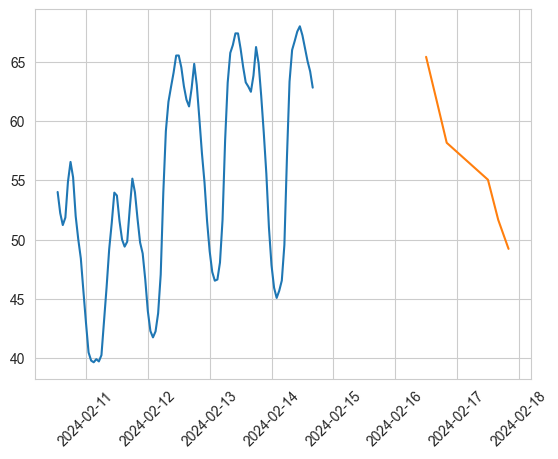

In [27]:
plot_df = forecast_en.copy() \
    .set_index('forecast_date')['q0.5']
plt.plot(df_en[-100:])
plt.plot(plot_df)
plt.xticks(rotation=45)
plt.show()

### Infections

In [28]:
forecast_infections = {
    'forecast_date': [start_date.strftime('%Y-%m-%d')] * 5,
    'target': ['infections'] * 5,
    'horizon': ['0 week', '1 week', '2 week', '3 week', '4 week'],
    # 'q0.025': ['NA'] * 5,
    # 'q0.25': ['NA'] * 5,
    # 'q0.5': ['NA'] * 5,
    # 'q0.75': ['NA'] * 5,
    # 'q0.975': ['NA'] * 5,
    'q0.025': [np.nan] * 5,
    'q0.25': [np.nan] * 5,
    'q0.5': [np.nan] * 5,
    'q0.75': [np.nan] * 5,
    'q0.975': [np.nan] * 5
}

forecast_infections = pd.DataFrame(forecast_infections)

In [29]:
forecast_infections

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-14,infections,0 week,NaN,NaN,NaN,NaN,NaN
1,2024-02-14,infections,1 week,NaN,NaN,NaN,NaN,NaN
2,2024-02-14,infections,2 week,NaN,NaN,NaN,NaN,NaN
3,2024-02-14,infections,3 week,NaN,NaN,NaN,NaN,NaN
4,2024-02-14,infections,4 week,NaN,NaN,NaN,NaN,NaN


## Merge results

Check results: Are they valid, forecast_date is right? The last entry might be cut off

In [30]:
forecasts = pd.concat([forecast_dax,forecast_en, forecast_infections]).reset_index().drop(columns=['index'])
forecasts

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-15,DAX,1 day,-1.476984,-0.435362,0.015949,0.487517,1.456696
1,2024-02-16,DAX,2 day,-1.776190,-0.551777,0.012975,0.596879,1.817112
2,2024-02-19,DAX,5 day,-2.495796,-0.755006,0.036821,0.860827,2.451627
3,2024-02-20,DAX,6 day,-2.928077,-0.910155,0.042492,1.024472,2.958117
4,2024-02-21,DAX,7 day,-3.065102,-0.928176,0.057648,1.122354,3.077342
5,2024-02-16 12:00:00,energy,36 hour,55.657841,62.031507,65.436939,67.835125,72.360136
6,2024-02-16 16:00:00,energy,40 hour,53.080652,58.730124,61.825507,64.374955,68.921919
7,2024-02-16 20:00:00,energy,44 hour,50.627047,55.583548,58.179247,60.609566,65.249897
8,2024-02-17 12:00:00,energy,60 hour,45.751310,52.106464,55.058335,57.246731,61.376985
9,2024-02-17 16:00:00,energy,64 hour,43.392177,49.023136,51.664958,54.004617,58.156823


If everything seems good: Override forecast_date

In [31]:
forecasts['forecast_date'] = [start_date.strftime('%Y-%m-%d') for _ in range(len(forecasts))]

In [32]:
forecasts

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-14,DAX,1 day,-1.476984,-0.435362,0.015949,0.487517,1.456696
1,2024-02-14,DAX,2 day,-1.776190,-0.551777,0.012975,0.596879,1.817112
2,2024-02-14,DAX,5 day,-2.495796,-0.755006,0.036821,0.860827,2.451627
3,2024-02-14,DAX,6 day,-2.928077,-0.910155,0.042492,1.024472,2.958117
4,2024-02-14,DAX,7 day,-3.065102,-0.928176,0.057648,1.122354,3.077342
5,2024-02-14,energy,36 hour,55.657841,62.031507,65.436939,67.835125,72.360136
6,2024-02-14,energy,40 hour,53.080652,58.730124,61.825507,64.374955,68.921919
7,2024-02-14,energy,44 hour,50.627047,55.583548,58.179247,60.609566,65.249897
8,2024-02-14,energy,60 hour,45.751310,52.106464,55.058335,57.246731,61.376985
9,2024-02-14,energy,64 hour,43.392177,49.023136,51.664958,54.004617,58.156823


### Check df & Save csv-File

In [33]:
from HelpFunctions.check_submission import check_submission_df

check_submission_df(forecasts)
forecasts.to_csv(f'./Abgaben/{start_date.strftime("%Y%m%d")}_JakePeralta.csv', na_rep='NA', index=False)

Start checking...
---------------------------
Checking the Columns...
Checking type of columns...
----WARNING: Some elements in q0.025 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.25 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.5 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.75 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.975 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

Checking if the Dates make sense...
Checking targets...
Checking quantiles...
Assume that -- infections -- is your NaN-target. Please DOUBLECHECK if this is correct.
---------------------------
Looks good!


/Users/elias/Desktop/PTSFC/HelpFunctions/check_submission.py:175: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  diffs[0] = 0
/Users/elias/Desktop/PTSFC/HelpFunctions/check_submission.py:175: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  diffs[0] = 0
/Users/elias/Desktop/PTSFC/HelpFunctions/check_submission.py:175: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  diffs[0] = 0
/Users/elias/Desktop/PTSFC/HelpFunctions/check